# Loading Libraries

In [1]:
!pip install pyspark py4j
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=b0317fd4d571715967edc3ed964fb17ca54ec730f19f6a966c0270e11348053f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from google.colab import drive
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import array_intersect, size, expr
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StringIndexerModel
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import split
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import max
from pyspark.sql.functions import min
from pyspark.mllib.recommendation import Rating
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.sql.functions import desc, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType
from pyspark.sql.functions import count, col, countDistinct, first
from pyspark.ml.recommendation import ALSModel
from pyspark.sql import functions as F
from pyspark.sql.functions import collect_set

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Ingestion and Preprocessing

## Loading Dataset

In [5]:
class DataLoader:
    def __init__(self, filename):
        """
        Initializes a DataLoader object.

        Args:
            filename (str): The name of the CSV file to load data from.
        """
        self.filename = filename

    def load_data(self, condition=True):
        """
        Load and preprocess data from a CSV file.

        Args:
            condition (bool, optional): A condition to determine whether to return filtered data or not.
                                        If True, returns filtered data; if False, returns sorted data.
                                        Defaults to True.

        Returns:
            pandas.DataFrame: A DataFrame containing the loaded and preprocessed data.
        """
        overall_df = pd.read_csv(self.filename)

        # Sorting the DataFrame by the 'Date' column in descending order --> Having User-Subreddit most recent interaction as the first one for each user.
        sorted_df = overall_df.sort_values(by='Date', ascending=False)

        sorted_df = sorted_df.drop(columns=['Post_Title', 'Date'])

        sorted_df.rename(columns={'PageRank_Within_Community': 'PR_Community'}, inplace=True)

        # Filtering the DataFrame to select rows where 'Community_Label' is 0, as this is the only community we're going to be focusing on.
        filtered_df = sorted_df[sorted_df['Community_Label'] == 0]

        # Returning the filtered or sorted DataFrame based on the condition
        if condition:
            return filtered_df
        else:
            return sorted_df

## Data Preprocessing

In [6]:
class DataPreprocessor:
    def normalize_score(self, df, column_name):
        """
        Normalize a specific column in a DataFrame between 0 and 1.

        Args:
            df (pandas.DataFrame): The DataFrame containing the data.
            column_name (str): The name of the column to be normalized.

        Returns:
            pandas.DataFrame: The DataFrame with the specified column normalized.
        """
        min_score = df[column_name].min()
        max_score = df[column_name].max()

        def normalize(x):
            return (x - min_score) / (max_score - min_score)

        df[column_name] = df[column_name].apply(normalize)
        return df

    def calculate_category_popularity(self, df):
        """
        Calculate and normalize the popularity of each 'Category' in the DataFrame.

        Args:
            df (pandas.DataFrame): The DataFrame containing the data.

        Returns:
            pandas.DataFrame: The DataFrame with 'Category_Popularity' values normalized.
        """
        category_popularity = df.groupby('Category')['User_ID'].nunique().reset_index()
        category_popularity.rename(columns={'User_ID': 'Category_Popularity'}, inplace=True)
        df = df.merge(category_popularity, on=['Category'], how='left')
        df = self.normalize_score(df, 'Category_Popularity')
        return df

    def calculate_subreddit_popularity(self, df):
        """
        Calculate and normalize the popularity of each 'Subreddit' in the DataFrame.

        Args:
            df (pandas.DataFrame): The DataFrame containing the data.

        Returns:
            pandas.DataFrame: The DataFrame with 'Subreddit_Popularity' values normalized.
        """
        subreddit_popularity = df.groupby('Subreddit')['User_ID'].nunique().reset_index()
        subreddit_popularity.rename(columns={'User_ID': 'Subreddit_Popularity'}, inplace=True)
        df = df.merge(subreddit_popularity, on=['Subreddit'], how='left')
        df = self.normalize_score(df, 'Subreddit_Popularity')
        return df

    def calculate_subreddit_average_upvotes(self, df):
        """
        Calculate and normalize the average upvotes for each 'Subreddit' in the DataFrame.

        Args:
            df (pandas.DataFrame): The DataFrame containing the data.

        Returns:
            pandas.DataFrame: The DataFrame with 'Average_Upvotes' values normalized.
        """
        subreddit_avg_upvotes = df.groupby('Subreddit')['Upvotes'].mean().reset_index()
        subreddit_avg_upvotes.rename(columns={'Upvotes': 'Average_Upvotes'}, inplace=True)
        df = df.merge(subreddit_avg_upvotes, on='Subreddit', how='left')
        df = self.normalize_score(df, 'Average_Upvotes')
        return df

    def calculate_subreddit_average_population(self, df):
        """
        Calculate and normalize the average population for each 'Subreddit' in the DataFrame.

        Args:
            df (pandas.DataFrame): The DataFrame containing the data.

        Returns:
            pandas.DataFrame: The DataFrame with 'Average_Population' values normalized.
        """
        subreddit_avg_population = df.groupby('Subreddit')['Population'].mean().reset_index()
        subreddit_avg_population.rename(columns={'Population': 'Average_Population'}, inplace=True)
        df = df.merge(subreddit_avg_population, on='Subreddit', how='left')
        df = self.normalize_score(df, 'Average_Population')
        return df

    def calculate_user_subreddit_interactions(self, df):
        """
        Calculate and normalize the interactions between 'User_ID' and 'Subreddit' in the DataFrame.

        Args:
            df (pandas.DataFrame): The DataFrame containing the data.

        Returns:
            pandas.DataFrame: The DataFrame with 'Interactions' values normalized.
        """
        user_subreddit_interactions = df.groupby(['User_ID', 'Subreddit']).size().reset_index(name='Interactions')
        df = df.merge(user_subreddit_interactions, on=['User_ID', 'Subreddit'], how='left')
        df = self.normalize_score(df, 'Interactions')
        return df

    def normalize_PageRank(self, df, column_name):
        """
        Normalize PageRank values in the DataFrame.

        Args:
            df (pandas.DataFrame): The DataFrame containing the data.
            column_name (str): The name of the PageRank column to be normalized.

        Returns:
            pandas.DataFrame: The DataFrame with the specified PageRank column normalized.
        """
        df = self.normalize_score(df, column_name)
        return df

## Score Calculation

In [7]:
class ImplicitScoreCalculator:
    def calculate_implicit_score(self, df, alpha, column_name):
        """
        Calculate implicit scores for each row in a DataFrame based on given parameters.

        Args:
            df (pandas.DataFrame): The DataFrame containing the data.
            alpha (float): Weight assigned to the original 'Implicit_Score' in the final score.
            column_name (str): The name of the original score column.

        Returns:
            pandas.DataFrame: The DataFrame with 'Implicit_Score' values calculated and adjusted.
        """
        df['Implicit_Score'] = (1 - alpha) * (df['Interactions'] * df['Category_Popularity'] * df['Subreddit_Popularity'] * df['Average_Upvotes'] * df['Average_Population'])\
                                           + alpha * df[column_name]

        lower_quartile = df['Implicit_Score'].quantile(0.25)
        upper_quartile = df['Implicit_Score'].quantile(0.75)
        iqr = upper_quartile - lower_quartile

        # Calculating lower and upper bounds
        lower_bound = lower_quartile - 1.5 * iqr
        upper_bound = upper_quartile + 1.5 * iqr

        # Setting scores below lower bound to lower bound, and scores above upper bound to upper bound
        df['Implicit_Score'] = df['Implicit_Score'].apply(lambda x: lower_bound if x < lower_bound else x)
        df['Implicit_Score'] = df['Implicit_Score'].apply(lambda x: upper_bound if x > upper_bound else x)

        return df

## Normalizing The Scores

In [8]:
class ScoreNormalizer:
    def compute_z_scores(self, df, column_name):
        """
        Calculate Z-scores for a specified column in a DataFrame.

        Args:
            df (pandas.DataFrame): The DataFrame containing the data.
            column_name (str): The name of the column for which Z-scores are calculated.

        Returns:
            pandas.DataFrame: A new DataFrame with Z-scores added as a new column.
        """
        # Calculating Z-scores for the specified column
        z_scores = stats.zscore(df[column_name])

        # Creating a new DataFrame with Z-scores
        z_scored_df = df.copy()
        z_scored_df['Normalized_' + column_name] = z_scores

        return z_scored_df

## Train Test Split

In [9]:
class TrainTestSplit:
    def StringToIndex(self, df, community, score):
        """
        Convert string columns to index columns using StringIndexer.

        Args:
            df (pyspark.sql.DataFrame): The input DataFrame.
            community (str): The name of the community column.
            score (str): The name of the score column.

        Returns:
            pyspark.sql.DataFrame: The DataFrame with indexed columns.
            list: List of StringIndexerModel objects.
        """
        indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in df.columns if column not in {community, score}]
        pipeline = Pipeline(stages=indexers)
        pipeline_model = pipeline.fit(df)
        df_indexed = pipeline_model.transform(df)
        string_indexer_models = [stage for stage in pipeline_model.stages if isinstance(stage, StringIndexerModel)]
        print("StringToIndex completed")
        return df_indexed, string_indexer_models

    def subreddit_per_user(self, df, x):
        """
        Filter users with a minimum number of unique subreddits.

        Args:
            df (pyspark.sql.DataFrame): The input DataFrame.
            x (int): Minimum number of unique subreddits per user.

        Returns:
            list: List of valid user indices.
        """
        user_subreddit_counts = df.groupBy('User_ID_index').agg(countDistinct('Subreddit_index').alias('nunique_Subreddit'))
        valid_users = user_subreddit_counts.filter(user_subreddit_counts['nunique_Subreddit'] >= x)
        valid_users_list = valid_users.select('User_ID_index').rdd.flatMap(lambda x: x).collect()
        record_count = len(valid_users_list)
        print("Total user count:", record_count)
        return valid_users_list

    def split_data(self, spark_df, valid_users_list):
        """
        Split the data into train and test sets.

        Args:
            spark_df (pyspark.sql.DataFrame): The input Spark DataFrame.
            valid_users_list (list): List of valid user indices.

        Returns:
            pyspark.sql.DataFrame: The train set.
            pyspark.sql.DataFrame: The test set.
        """
        # Selecting only the relevant columns from the Spark DataFrame
        latest_interactions = spark_df.select(
            'User_ID_index', 'User_ID', 'Subreddit_index', 'Subreddit',
            'Community_Label', 'Normalized_Implicit_Score'
        ).groupBy('User_ID_index').agg(
            # Geting the first row for each user (most recent interaction)
            first(col('User_ID')).alias('User_ID'),
            first(col('Subreddit_index')).alias('Subreddit_index'),
            first(col('Subreddit')).alias('Subreddit'),
            first(col('Community_Label')).alias('Community_Label'),
            first(col('Normalized_Implicit_Score')).alias('Normalized_Implicit_Score')
        )

        # Filtering the test set based on valid users
        test = latest_interactions.filter(col('User_ID_index').isin(valid_users_list))

        # Creating a set of subreddits from the test set for fast lookup
        test_subreddits = set(test.select('Subreddit_index').distinct().rdd.flatMap(lambda x: x).collect())

        # Including all records for users in the train set, excluding those with matching subreddits in the test set
        train = spark_df.alias('a').join(
            test.select('User_ID_index', 'Subreddit_index').alias('b'),
            (col('a.User_ID_index') == col('b.User_ID_index')) &
            (col('a.Subreddit_index') == col('b.Subreddit_index')),
            'left_anti'
        ).select(
            'a.User_ID_index', 'a.Subreddit_index',
            'a.Community_Label', 'a.Normalized_Implicit_Score'
        )

        print("split_data completed")

        df_size = spark_df.count()
        print("Size of the entire dataset:", df_size)
        train_size = train.count()
        print("Size of the train set:", train_size)
        test_size = test.count()
        print("Size of the test set:", test_size)

        return train, test

# ALS

In [10]:
class ALSCustom:
    def als_models(self, ranks, iterations, regularization, u_col, i_col, r_col):
        """
        Generate a list of ALS models with different hyperparameters.

        Args:
            ranks (list): List of rank values for the ALS model.
            iterations (list): List of maximum iterations values for the ALS model.
            regularization (list): List of regularization parameters for the ALS model.
            u_col (str): User column name.
            i_col (str): Item column name.
            r_col (str): Rating column name.

        Returns:
            list: List of tuples containing model name and ALS model instances.
        """
        als_list = []
        idx = 0

        for k in ranks:
            for itr in iterations:
                for reg_p in regularization:
                    model_name = f"model_{idx}"
                    idx = idx + 1
                    als_model = ALS(
                        maxIter=itr,
                        regParam=reg_p,
                        rank=k,
                        implicitPrefs=True,
                        userCol=u_col,
                        itemCol=i_col,
                        ratingCol=r_col,
                        coldStartStrategy="drop",
                        nonnegative=True
                    )
                    als_list.append((model_name, als_model))
                    print(f"{model_name}, rank: {k}, maxIterations: {itr}, regParam: {reg_p}")
        print("list_of_models_complete")
        return als_list

    def model_fit(self, df_train, models, alpha, x):
        """
        Fit and save ALS models to specified paths.

        Args:
            df_train (pyspark.sql.DataFrame): The training DataFrame.
            models (list): List of tuples containing model name and ALS model instances.
            alpha (float): Alpha parameter for model path.
            x (int): Minimum subreddit value for model path.

        Returns:
            None
        """
        for name, model in models:
            fitted = model.fit(df_train)
            fitted.save(f"{model_path}/alpha_{alpha}/train_df/min_subreddit{x}/{name}")
            print(name, " complete")

        print("model_fit complete")

# Recommendations

In [11]:
class Recommender:
    def load_models(self, model_path, alpha, num_models, x):
        """
        Load ALS models from specified paths.

        Args:
            model_path (str): The base path where ALS models are saved.
            alpha (float): Alpha parameter for model path.
            num_models (int): Number of ALS models to load.
            x (int): Minimum subreddit value for model path.

        Returns:
            list: List of tuples containing model name and loaded ALS model instances.
        """
        loaded_models = []

        for idx in range(num_models):
            model_name = f"model_{idx}"
            model = ALSModel.load(f"{model_path}/alpha_{alpha}/train_df/min_subreddit{x}/{model_name}")
            loaded_models.append((model_name, model))

        return loaded_models

    def generate_recommendation(self, model, test, k):
        """
        Generate recommendations using an ALS model.

        Args:
            model (pyspark.ml.recommendation.ALSModel): The ALS model for generating recommendations.
            test (pyspark.sql.DataFrame): The test DataFrame.
            k (int): The number of recommendations to generate.

        Returns:
            pyspark.sql.DataFrame: DataFrame containing the top-k recommendations.
        """
        top_k_recommendations = model.recommendForUserSubset(test, k)
        top_k_recommendations = top_k_recommendations.withColumnRenamed("recommendations", "sorted_recommendations")
        print("generate_recommendation complete")
        return top_k_recommendations

    def evaluate_recommendation(self, model, train, test, recommendations):
        """
        Evaluate the quality of recommendations generated by an ALS model.

        Args:
            model (pyspark.ml.recommendation.ALSModel): The ALS model for generating recommendations.
            train (pyspark.sql.DataFrame): The training DataFrame.
            test (pyspark.sql.DataFrame): The test DataFrame.
            recommendations (pyspark.sql.DataFrame): DataFrame containing recommendations.

        Returns:
            float: Ratio of successful recommendations to total test rows.
            float: Ratio of top recommendations to total test rows.
        """
        # Iterating over user_ids in the test_df
        user_ids = test.select('User_ID_index').distinct().rdd.flatMap(lambda x: x).collect()

        for user_id in user_ids:
            # Filtering train and test data for the current user
            intersection_df = recommendations.join(test, on=["User_ID_index"], how="inner")

            # Converting 'Subreddit_index' to an array of integers
            intersection_df = intersection_df.withColumn("Subreddit_index_array", expr("array(int(Subreddit_index))"))

            # Calculating the intersection between the arrays in 'sorted_recommendations' and 'Subreddit_index_array'
            intersection_df = intersection_df.withColumn(
                "intersection",
                array_intersect("sorted_recommendations.Subreddit_index", "Subreddit_index_array"))

            intersection_df = intersection_df.withColumn(
                "intersection_index",
                expr("array_position(sorted_recommendations.Subreddit_index, intersection[0])"))

        non_empty_rows = intersection_df.filter(col("intersection").isNotNull() & (col("intersection").getItem(0).isNotNull()))
        filtered_df = intersection_df.filter(col("intersection_index") == 1)

        count_non_empty_rows = non_empty_rows.count()
        count_top_recommendation = filtered_df.count()
        total_test_rows = test.count()
        # ratio is the hit@k precision score
        ratio = count_non_empty_rows / total_test_rows
        # top_recommendation_ratio is the ratio of counting the top recommendation = actual subreddit item over the length of the test set
        top_recommendation_ratio = count_top_recommendation / total_test_rows

        return ratio, top_recommendation_ratio

    def map_to_original_values(self, indexed_recommendations, string_idx_model):
        """
        Map indexed recommendations to their original values.

        Args:
            indexed_recommendations (list): List of indexed recommendations.
            string_idx_model (pyspark.ml.feature.StringIndexerModel): String indexer model.

        Returns:
            list: List of original values corresponding to the indexed recommendations.
        """
        return [string_idx_model.labels[int(index)] for index in indexed_recommendations]

    def display_recommendation(self, recommendations, test, string_idx_models, k):
        """
        Display recommendations for users in the test set.

        Args:
            recommendations (pyspark.sql.DataFrame): DataFrame containing recommendations.
            test (pyspark.sql.DataFrame): The test DataFrame.
            string_idx_models (list): List of string indexer models.
            k (int): The number of recommendations to display.

        Returns:
            None
        """
        rec_alias = recommendations.alias("rec")
        test_alias = test.alias("test")
        recommendations_with_User_ID = rec_alias.join(test_alias, col("rec.User_ID_index") == col("test.User_ID_index"), "left")
        # Selecting relevant columns and renaming them
        recommendations_with_User_ID = recommendations_with_User_ID.select(col("test.User_ID").alias("User_ID"), col("rec.sorted_recommendations"))

        # Retrieving values from the recommendations column
        rows = recommendations_with_User_ID.collect()
        counter = 0
        print("User_ID |", "| recommendations")

        for row in rows:
            User_ID = row["User_ID"]
            user_recommendations = [int(rec.Subreddit_index) for rec in row.sorted_recommendations]
            recommendations_list = self.map_to_original_values(user_recommendations, string_idx_models[0])
            print(User_ID, recommendations_list)
            counter = counter + 1
            if (counter > k):
              break

        print("---------------------------------------------------------------------")

    def plot_recommendation(self, recommendations, string_idx_models, test, user_id):
        """
        Plot recommendations and similarity scores for a specific user.

        Args:
            recommendations (pyspark.sql.DataFrame): DataFrame containing recommendations.
            string_idx_models (list): List of string indexer models.
            test (pyspark.sql.DataFrame): The test DataFrame.
            user_id (int): User ID for which to plot recommendations.

        Returns:
            None
        """
        rec_alias = recommendations.alias("rec")
        test_alias = test.alias("test")
        recommendations_with_User_ID = rec_alias.join(test_alias, col("rec.User_ID_index") == col("test.User_ID_index"), "left")
        # Selecting relevant columns and renaming them
        recommendations_with_User_ID = recommendations_with_User_ID.select(col("test.User_ID").alias("User_ID"), col("rec.sorted_recommendations"))
        recommendations_list = []  # List to store recommendations
        similarity_scores = []  # List to store similarity scores

        # Collecting the recommendations DataFrame to extract data
        recommendations_data = recommendations_with_User_ID.filter(recommendations_with_User_ID.User_ID == user_id).collect()

        for row in recommendations_data:
            user_recommendations = [int(rec.Subreddit_index) for rec in row.sorted_recommendations]
            user_scores = [rec[1] for rec in row.sorted_recommendations]

            recommendations_list.extend(self.map_to_original_values(user_recommendations, string_idx_models[0]))
            similarity_scores.extend(user_scores)

        plt.figure(figsize=(10, 6))
        plt.plot(recommendations_list, similarity_scores, marker='o', linestyle='-')
        plt.xlabel('Recommendations')
        plt.ylabel('Similarity Scores')
        plt.title('Recommendations vs. Similarity Scores')
        plt.grid(True)

        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

# Interesting Plots

In [12]:
class AccuracyPlots:
    def min_subreddit_plot(self, alpha_score, min_subreddits, highest_precision_score):
        """
        Create a line chart showing the relationship between min_subreddits and highest_precision_score.
        Create a dataframe showing the relationship between min_subreddits, alpha, and highest_precision_score.

        Args:
            alpha_score (dict): A dictionary mapping alpha values to their corresponding scores.
            min_subreddits (dict): A dictionary mapping alpha values to their corresponding min_subreddit values.
            highest_precision_score (dict): A dictionary mapping alpha values to their corresponding highest precision scores.

        Returns:
            None
        """
        # Extracting keys and values from dictionaries
        min_subreddits_values = list(min_subreddits.values())
        highest_precision_values = list(highest_precision_score.values())
        alpha_values = list(alpha_score.values())

        df = pd.DataFrame({
            'min_subreddit': min_subreddits_values,
            'alpha': alpha_values,
            'highest_precision_score': highest_precision_values
        })

        # Creating a line chart
        plt.figure(figsize=(10, 6))
        plt.plot(min_subreddits_values, highest_precision_values, marker='o', linestyle='-')
        plt.xlabel('min_subreddits')
        plt.ylabel('highest_precision_score')
        plt.title('min_subreddits vs. highest_precision_score')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        print(df)

# Notes

This Notebook is split into two parts:
 - The first part aims to create a community-based recommendation system with the inclusion of user influence within the community.
 - The second part aims to create an overall recommendation system with the inclusion of the user influence across the whole network

The implemented recommendation system follows a collaborative filtering approach using Spark's ALS (Alternating Least Squares) recommendation models.

The notebook is composed of several classes and 2 main sections.
  - First class aims to load the dataset and returns it in the form of a dataframe
  - Second class aims to perform some data preprocessing in order to have certain variables that can be used to compute the implicit score for the ALS models.
  - Third class computes the implicit scores
  - Fourth class normalizes the implicit scores using Z-Score Normalization
  - Fifth class splits the data into train and test set using the leave one out approach, where I store the most recent user-subreddit interaction in the test set and the remaining in the train set. The reason this approach has been implemented is to ensure that I train my models on all the users, since ALS struggles with cold start. Note: User-Subreddit interaction in the test set cannot also be stored in the train set.
  - Sixth class is fitting the ALS models
  - Seventh class is generating, displaying, evaluating and plotting recommendations
  - Eigth and final class is performing two interesting plots:
      
      - The first one is to view the best model accuracy for each minimum number of subreddits that is used as a threshold when performing train/test split
      - The second one is to view which alpha provides a more accurate model in the 3 threshold values (minimum subreddit = 3, 4, 5)

  - The two main section serve as a way to compare the hit@k precision scores and to determing whether or not a community-based recommendation system provides more accurate recommendations than a general recommendation system.
  - Another comparison is between the user influence within a community and the user influence across the whole network.

  Three observations can be made:
  - First observation: a community-based recommendation system seems to provide more accurate recommendations than the general one (hit@k accuracy around +10%).
  - Second observation: user influence within a community seems to have more importance than the user influence across the network when performing recommendations.

      - Alpha represents the importance we want to give to the pagerank scores, hence a higher alpha means more weight for the pagerank scores.
  - The more we increase the minimum subreddit threshold, the higher the accuracy scores of the ALS models, which is understandable, because the more we learn about the user, the more accurate our recommendations is going to be.

# MAIN w/ Community

In [15]:
model_path = "/content/models_ALS_Final/community"
file_path = '/content/drive/MyDrive/Thesis Data/overall_df.csv'
if __name__ == "__main__":
    data_loader = DataLoader(file_path)
    # To give more/less importance of the PageRank scores
    alphas = [0.2, 0.4, 0.6, 0.8]
    # Train/Test split threshold
    min_subreddits = [3, 4, 5]
    # Initializing empty dictionaries
    highest_precision_score = {'0': 0, '1': 0, '2': 0}
    highest_top_recommendation_precision_score = {'0': 0, '1': 0, '2': 0}
    alpha_score = {'0': 0, '1': 0, '2': 0}
    name_of_model = {'0': '0', '1': '0', '2': '0'}
    string_idxer = {'0': None, '1': None, '2': None}
    for alpha in alphas:
        # True --> condition to return the dataframe after performing community filtering
        overall_df = data_loader.load_data(True)
        preprocessor = DataPreprocessor()
        implicit_score_calculator = ImplicitScoreCalculator()
        score_normalizer = ScoreNormalizer()
        overall_df = preprocessor.calculate_subreddit_popularity(overall_df)
        overall_df = preprocessor.calculate_category_popularity(overall_df)
        overall_df = preprocessor.calculate_subreddit_average_upvotes(overall_df)
        overall_df = preprocessor.calculate_subreddit_average_population(overall_df)
        overall_df = preprocessor.calculate_user_subreddit_interactions(overall_df)
        overall_df = preprocessor.normalize_PageRank(overall_df, 'PR_Community')
        overall_df = overall_df.drop(columns=['Upvotes'])
        overall_df = implicit_score_calculator.calculate_implicit_score(overall_df, alpha, 'PR_Community')
        df_updated = overall_df.drop_duplicates()
        norm_df = score_normalizer.compute_z_scores(df_updated, 'Implicit_Score')
        spark = SparkSession.builder.appName("df_to_spark_df").getOrCreate()
        spark_df = spark.createDataFrame(norm_df)
        train_test_splitter = TrainTestSplit()
        for x in min_subreddits:
            df_idx_list, string_idx_models = train_test_splitter.StringToIndex(spark_df, 'Community_Label','Normalized_Implicit_Score')
            valid_users_list = train_test_splitter.subreddit_per_user(df_idx_list, x)
            train, test = train_test_splitter.split_data(df_idx_list, valid_users_list)
            # ALS hyperparameters
            ranks = [3, 4, 5]
            maxIters = [10, 15]
            regParams = [0.001, 0.01, 0.1]
            als_custom = ALSCustom()
            models = als_custom.als_models(ranks, maxIters, regParams, "User_ID_index", "Subreddit_index", "Normalized_Implicit_Score")
            als_custom.model_fit(train, models, alpha, x)
            recommender = Recommender()
            loaded_models = recommender.load_models(model_path, alpha, len(models), x)
            for model_name, model in loaded_models:
                recommendations = recommender.generate_recommendation(model, test, 15)
                precision_score, top_recommendation_precision_score = recommender.evaluate_recommendation(model, train, test, recommendations)
                print(f'{model_name} Hit@k: {precision_score}, Top Recommendation Precision: {top_recommendation_precision_score}')

                # Storing best model values
                if x == 3:
                    if highest_precision_score['0'] < precision_score:
                        highest_precision_score['0'] = precision_score
                        highest_top_recommendation_precision_score = top_recommendation_precision_score
                        alpha_score['0'] = alpha
                        name_of_model['0'] = model_name
                        string_idxer['0'] = string_idx_models
                elif x == 4:
                    if highest_precision_score['1'] < precision_score:
                        highest_precision_score['1'] = precision_score
                        highest_top_recommendation_precision_score = top_recommendation_precision_score
                        alpha_score['1'] = alpha
                        name_of_model['1'] = model_name
                        string_idxer['1'] = string_idx_models
                else:
                    if highest_precision_score['2'] < precision_score:
                        highest_precision_score['2'] = precision_score
                        highest_top_recommendation_precision_score = top_recommendation_precision_score
                        alpha_score['2'] = alpha
                        name_of_model['2'] = model_name
                        string_idxer['2'] = string_idx_models

            print(f'min_subreddit: {x} complete')
            print("---------------------------------------------------------------------")

        print(f'alpha: {alpha} complete')
        print("=====================================================================")

StringToIndex completed
Total user count: 172
split_data completed
Size of the entire dataset: 3172
Size of the train set: 3000
Size of the test set: 172
model_0, rank: 3, maxIterations: 10, regParam: 0.001
model_1, rank: 3, maxIterations: 10, regParam: 0.01
model_2, rank: 3, maxIterations: 10, regParam: 0.1
model_3, rank: 3, maxIterations: 15, regParam: 0.001
model_4, rank: 3, maxIterations: 15, regParam: 0.01
model_5, rank: 3, maxIterations: 15, regParam: 0.1
model_6, rank: 4, maxIterations: 10, regParam: 0.001
model_7, rank: 4, maxIterations: 10, regParam: 0.01
model_8, rank: 4, maxIterations: 10, regParam: 0.1
model_9, rank: 4, maxIterations: 15, regParam: 0.001
model_10, rank: 4, maxIterations: 15, regParam: 0.01
model_11, rank: 4, maxIterations: 15, regParam: 0.1
model_12, rank: 5, maxIterations: 10, regParam: 0.001
model_13, rank: 5, maxIterations: 10, regParam: 0.01
model_14, rank: 5, maxIterations: 10, regParam: 0.1
model_15, rank: 5, maxIterations: 15, regParam: 0.001
model_1

generate_recommendation complete
User_ID | | recommendations
adviceKiwi ['television', 'movies', 'todayilearned', 'videos', 'technology', 'funny', 'mildlyinteresting', 'pics', 'OldSchoolCool', 'AdviceAnimals', 'WTF', 'aww', 'explainlikeimfive', 'interestingasfuck', 'gaming']
dandroid126 ['todayilearned', 'funny', 'mildlyinteresting', 'pics', 'AdviceAnimals', 'technology', 'WTF', 'aww', 'videos', 'explainlikeimfive', 'OldSchoolCool', 'interestingasfuck', 'dataisbeautiful', 'gaming', 'nottheonion']
Schiffy94 ['politics', 'news', 'worldnews', 'technology', 'todayilearned', 'funny', 'AdviceAnimals', 'mildlyinteresting', 'pics', 'nottheonion', 'interestingasfuck', 'aww', 'WTF', 'videos', 'AskReddit']
Rosebunse ['television', 'todayilearned', 'movies', 'videos', 'technology', 'funny', 'mildlyinteresting', 'pics', 'AdviceAnimals', 'WTF', 'OldSchoolCool', 'aww', 'explainlikeimfive', 'interestingasfuck', 'dataisbeautiful']
McFeely_Smackup ['television', 'movies', 'todayilearned', 'videos', 'tec

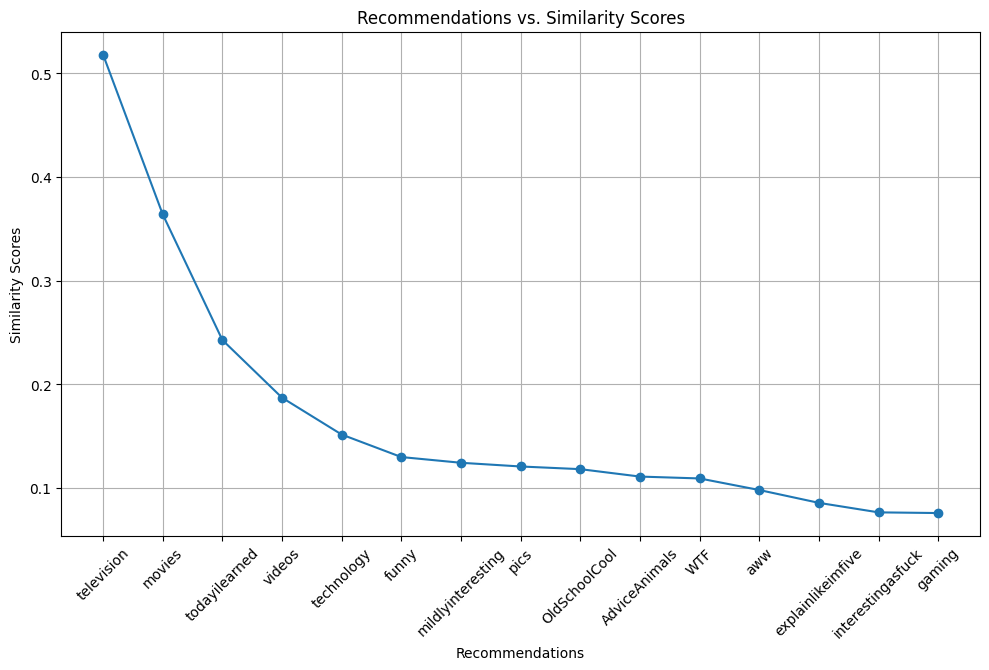

In [16]:
for alpha, name, s_idx, x in zip(alpha_score.values(), name_of_model.values(), string_idxer.values(), min_subreddits):
    loaded_models = {model_name: model for model_name, model in recommender.load_models(model_path, alpha, len(models), x)}
    if name in loaded_models:
        desired_model = loaded_models[name]
        recommendations = recommender.generate_recommendation(desired_model, test, 15)
        # Displaying 10 recommendation for 5 users
        recommender.display_recommendation(recommendations, test, s_idx, 4)
        # Plotting the 10 recommendations for one of the 5 users
        recommender.plot_recommendation(recommendations, s_idx, test, 'adviceKiwi')
        break
    else:
        print(f"Model '{name}' not found in loaded models.")

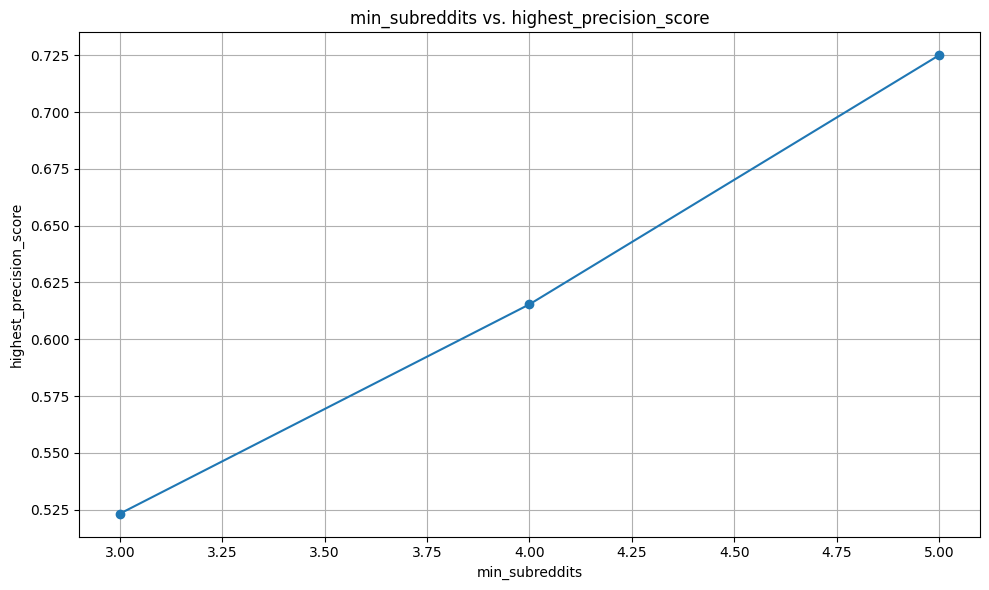

   min_subreddit  alpha  highest_precision_score
0              3    0.8                 0.523256
1              4    0.8                 0.615385
2              5    0.4                 0.725000


In [17]:
if __name__ == "__main__":
    keys = ['0', '1', '2']
    min_subreddits_dict = {keys[i]: min_subreddits[i] for i in range(len(keys))}
    plots = AccuracyPlots()
    # Viewing the highest precision score & alpha for each train/test split threshold
    plots.min_subreddit_plot(alpha_score, min_subreddits_dict, highest_precision_score)

# Main w/o Community

In [18]:
model_path = "/content/models_ALS_Final/No_community"
file_path = '/content/drive/MyDrive/Thesis Data/overall_df.csv'
if __name__ == "__main__":
    data_loader = DataLoader(file_path)
    # To give more/less importance of the PageRank scores
    alphas = [0.2, 0.4, 0.6, 0.8]
    # Train/Test split threshold
    min_subreddits = [3, 4, 5]
    # Initializing empty dictionaries
    highest_precision_score = {'0': 0, '1': 0, '2': 0}
    highest_top_recommendation_precision_score = {'0': 0, '1': 0, '2': 0}
    alpha_score = {'0': 0, '1': 0, '2': 0}
    name_of_model = {'0': '0', '1': '0', '2': '0'}
    string_idxer = {'0': None, '1': None, '2': None}
    for alpha in alphas:
        # False --> condition to return the entire dataframe w/o community filtering
        overall_df = data_loader.load_data(False)
        preprocessor = DataPreprocessor()
        implicit_score_calculator = ImplicitScoreCalculator()
        score_normalizer = ScoreNormalizer()
        overall_df = preprocessor.calculate_subreddit_popularity(overall_df)
        overall_df = preprocessor.calculate_category_popularity(overall_df)
        overall_df = preprocessor.calculate_subreddit_average_upvotes(overall_df)
        overall_df = preprocessor.calculate_subreddit_average_population(overall_df)
        overall_df = preprocessor.calculate_user_subreddit_interactions(overall_df)
        overall_df = preprocessor.normalize_PageRank(overall_df, 'PageRank')
        overall_df = overall_df.drop(columns=['Upvotes'])
        overall_df = implicit_score_calculator.calculate_implicit_score(overall_df, alpha, 'PageRank')
        df_updated = overall_df.drop_duplicates()
        norm_df = score_normalizer.compute_z_scores(df_updated, 'Implicit_Score')
        spark = SparkSession.builder.appName("df_to_spark_df").getOrCreate()
        spark_df = spark.createDataFrame(norm_df)
        train_test_splitter = TrainTestSplit()
        for x in min_subreddits:
            df_idx_list, string_idx_models = train_test_splitter.StringToIndex(spark_df, 'Community_Label','Normalized_Implicit_Score')
            valid_users_list = train_test_splitter.subreddit_per_user(df_idx_list, x)
            train, test = train_test_splitter.split_data(df_idx_list, valid_users_list)
            # ALS hyperparameters
            ranks = [3, 4, 5]
            maxIters = [10, 15]
            regParams = [0.001, 0.01, 0.1]
            als_custom = ALSCustom()
            models = als_custom.als_models(ranks, maxIters, regParams, "User_ID_index", "Subreddit_index", "Normalized_Implicit_Score")
            als_custom.model_fit(train, models, alpha, x)
            recommender = Recommender()
            loaded_models = recommender.load_models(model_path, alpha, len(models), x)
            for model_name, model in loaded_models:
                recommendations = recommender.generate_recommendation(model, test, 15)
                precision_score, top_recommendation_precision_score = recommender.evaluate_recommendation(model, train, test, recommendations)
                print(f'{model_name} Hit@k: {precision_score}, Top Recommendation Precision: {top_recommendation_precision_score}')

                # Storing best model values
                if x == 3:
                    if highest_precision_score['0'] < precision_score:
                        highest_precision_score['0'] = precision_score
                        highest_top_recommendation_precision_score = top_recommendation_precision_score
                        alpha_score['0'] = alpha
                        name_of_model['0'] = model_name
                        string_idxer['0'] = string_idx_models
                elif x == 4:
                    if highest_precision_score['1'] < precision_score:
                        highest_precision_score['1'] = precision_score
                        highest_top_recommendation_precision_score = top_recommendation_precision_score
                        alpha_score['1'] = alpha
                        name_of_model['1'] = model_name
                        string_idxer['1'] = string_idx_models
                else:
                    if highest_precision_score['2'] < precision_score:
                        highest_precision_score['2'] = precision_score
                        highest_top_recommendation_precision_score = top_recommendation_precision_score
                        alpha_score['2'] = alpha
                        name_of_model['2'] = model_name
                        string_idxer['2'] = string_idx_models

            print(f'min_subreddit: {x} complete')
            print("---------------------------------------------------------------------")

        print(f'alpha: {alpha} complete')
        print("=====================================================================")

StringToIndex completed
Total user count: 245
split_data completed
Size of the entire dataset: 9788
Size of the train set: 9542
Size of the test set: 245
model_0, rank: 3, maxIterations: 10, regParam: 0.001
model_1, rank: 3, maxIterations: 10, regParam: 0.01
model_2, rank: 3, maxIterations: 10, regParam: 0.1
model_3, rank: 3, maxIterations: 15, regParam: 0.001
model_4, rank: 3, maxIterations: 15, regParam: 0.01
model_5, rank: 3, maxIterations: 15, regParam: 0.1
model_6, rank: 4, maxIterations: 10, regParam: 0.001
model_7, rank: 4, maxIterations: 10, regParam: 0.01
model_8, rank: 4, maxIterations: 10, regParam: 0.1
model_9, rank: 4, maxIterations: 15, regParam: 0.001
model_10, rank: 4, maxIterations: 15, regParam: 0.01
model_11, rank: 4, maxIterations: 15, regParam: 0.1
model_12, rank: 5, maxIterations: 10, regParam: 0.001
model_13, rank: 5, maxIterations: 10, regParam: 0.01
model_14, rank: 5, maxIterations: 10, regParam: 0.1
model_15, rank: 5, maxIterations: 15, regParam: 0.001
model_1

generate_recommendation complete
User_ID | | recommendations
Black_Moons ['television', 'todayilearned', 'movies', 'technology', 'worldnews', 'videos', 'AdviceAnimals', 'news', 'funny', 'WTF', 'explainlikeimfive', 'mildlyinteresting', 'pics', 'pcmasterrace', 'aww']
Hephaestus_God ['television', 'todayilearned', 'movies', 'technology', 'worldnews', 'videos', 'AdviceAnimals', 'funny', 'WTF', 'news', 'explainlikeimfive', 'mildlyinteresting', 'pics', 'pcmasterrace', 'aww']
why_rob_y ['nba', 'CryptoCurrency', 'television', 'movies', 'todayilearned', 'technology', 'worldnews', 'videos', 'AdviceAnimals', 'funny', 'news', 'WTF', 'explainlikeimfive', 'mildlyinteresting', 'pics']
theveryrealreal ['television', 'todayilearned', 'movies', 'technology', 'worldnews', 'videos', 'AdviceAnimals', 'funny', 'WTF', 'news', 'explainlikeimfive', 'mildlyinteresting', 'pics', 'pcmasterrace', 'aww']
walterpeck1 ['television', 'todayilearned', 'movies', 'technology', 'worldnews', 'videos', 'AdviceAnimals', 'fun

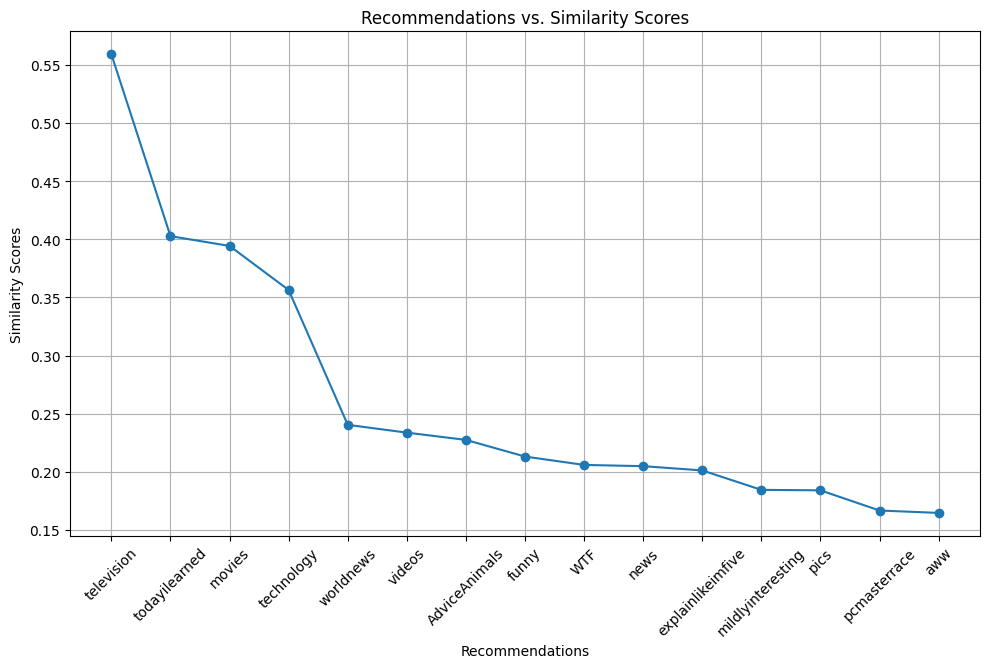

In [19]:
for alpha, name, s_idx, x in zip(alpha_score.values(), name_of_model.values(), string_idxer.values(), min_subreddits):
    loaded_models = {model_name: model for model_name, model in recommender.load_models(model_path, alpha, len(models), x)}
    if name in loaded_models:
        desired_model = loaded_models[name]
        recommendations = recommender.generate_recommendation(desired_model, test, 15)
        # Displaying 10 recommendation for 5 users
        recommender.display_recommendation(recommendations, test, s_idx, 4)
        # Plotting the 10 recommendations for one of the 5 users
        recommender.plot_recommendation(recommendations, s_idx, test, 'adviceKiwi')
        break
    else:
        print(f"Model '{name}' not found in loaded models.")

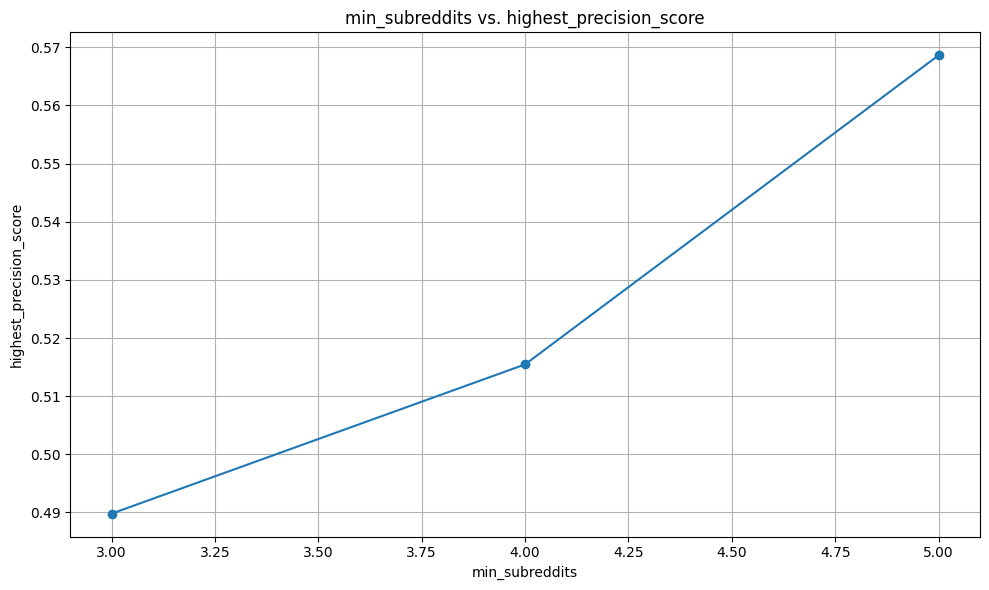

   min_subreddit  alpha  highest_precision_score
0              3    0.4                 0.489796
1              4    0.2                 0.515464
2              5    0.2                 0.568627


In [20]:
if __name__ == "__main__":
    keys = ['0', '1', '2']
    min_subreddits_dict = {keys[i]: min_subreddits[i] for i in range(len(keys))}
    plots = AccuracyPlots()
    # Viewing the highest precision score & alpha for each train/test split threshold
    plots.min_subreddit_plot(alpha_score, min_subreddits_dict, highest_precision_score)

In [21]:
import shutil

# Replace '/content/models_ALS_Final' with the path to your folder
folder_path = '/content/models_ALS_Final'

# Zip the folder
shutil.make_archive('/content/models_ALS_Final', 'zip', folder_path)

# Download the zip file
from google.colab import files
files.download('/content/models_ALS_Final.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>